<a href="https://colab.research.google.com/github/varnitvishwakarma/DEEP_LEARNING/blob/main/facegennew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the paths
train_sketch_path = '/content/drive/MyDrive/sketch_to_face/dataset/sketches'
train_photo_path = '/content/drive/MyDrive/sketch_to_face/dataset/photos'

# Load the datasets
batch_size = 32
img_size = (128, 128)

train_sketch_ds = image_dataset_from_directory(
    train_sketch_path,
    label_mode=None,
    image_size=img_size,
    batch_size=batch_size
)

train_photo_ds = image_dataset_from_directory(
    train_photo_path,
    label_mode=None,
    image_size=img_size,
    batch_size=batch_size
)

# Normalize the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

train_sketch_ds = train_sketch_ds.map(normalize)
train_photo_ds = train_photo_ds.map(normalize)

# Combine the datasets into a single dataset
train_ds = tf.data.Dataset.zip((train_sketch_ds, train_photo_ds))

# Prefetch for better performance
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Found 188 files belonging to 1 classes.
Found 188 files belonging to 1 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# plt.imshow((generated_image[0] + 1) / 2)  # Rescale to [0, 1] for display purposes


In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)


tf.Tensor([[0.00027036]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 2000
noise_dim = 100
num_examples_to_generate = 16

# Seed for visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(sketch_images, photo_images):
    noise = tf.random.normal([sketch_images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(photo_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        for sketch_images, photo_images in dataset:
            gen_loss, disc_loss = train_step(sketch_images, photo_images)

        print(f'Epoch {epoch+1}, gen loss={gen_loss.numpy()}, disc loss={disc_loss.numpy()}')

train(train_ds, EPOCHS)

Epoch 1, gen loss=1.2086001634597778, disc loss=0.5757641792297363


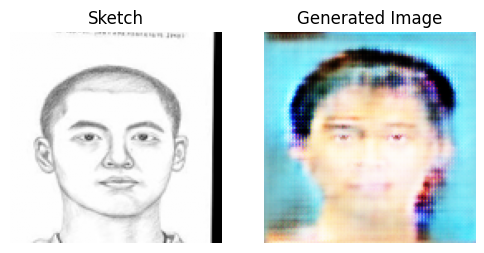

In [10]:
from PIL import Image


def load_and_preprocess_image(file_path):
    img = Image.open(file_path).convert('RGB')
    img = img.resize((128, 128))
    img = np.array(img) / 127.5 - 1.0  # Normalize to [-1, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def generate_image_from_sketch(file_path):
    sketch_image = load_and_preprocess_image(file_path)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    generated_image = (generated_image[0] + 1) / 2.0  # Rescale to [0, 1]

    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.title('Sketch')
    plt.imshow((sketch_image[0] + 1) / 2.0)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Generated Image')
    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()



# Example usage
sketch_url = '/content/drive/MyDrive/sketch_to_face/dataset/sketches/M2-029-01-sz1.jpg'
generate_image_from_sketch(sketch_url)

In [ ]:
generator_save_path = 'generator_model'
discriminator_save_path = 'discriminator_model'

generator.save(generator_save_path)
discriminator.save(discriminator_save_path)

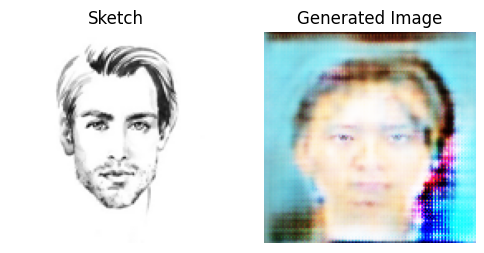

In [12]:
sketch_url1 = "/content/predict2.jpg"
generate_image_from_sketch(sketch_url1)

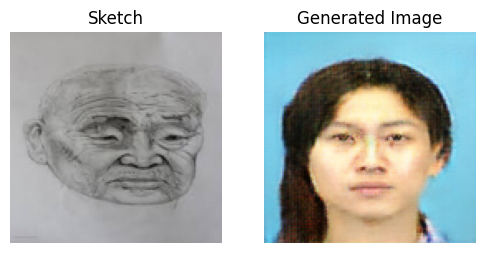

In [ ]:
sketch_url1 = "/content/images.jpg"
generate_image_from_sketch(sketch_url1)

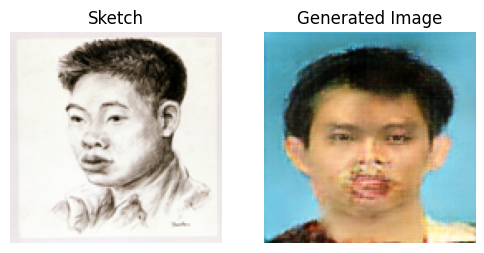

In [ ]:

sketch_url1 = "/content/artwork-chinese-man-china-1945-artist-john-g-hanlen-5a46fa-1024.jpg"
generate_image_from_sketch(sketch_url1)

In [ ]:
# //==================================================================================================================================